In [6]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import franchiseplayers
from headers import get_headers
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = get_headers()

In [7]:
## This is function to draw nba_court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [8]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [9]:
from nba_api.stats.endpoints import teamdashptshots

## Use this to determine frequency of stuff

td = teamdashptshots.TeamDashPtShots(team_id=team_to_id['LAL'], headers=headers)
tdd = td.get_data_frames()[0]
tdd.head()

,TEAM_ID,TEAM_NAME,SORT_ORDER,G,SHOT_TYPE,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,1610612747,Los Angeles Lakers,1,57,Totals,1.000,2448,5033,0.486,0.550,0.648,1812,3263,0.555,0.352,636,1770,0.359
1,1610612747,Los Angeles Lakers,2,57,Catch and Shoot,0.284,545,1427,0.382,0.549,0.035,68,178,0.382,0.248,477,1249,0.382
2,1610612747,Los Angeles Lakers,3,57,Pullups,0.248,441,1246,0.354,0.413,0.151,295,760,0.388,0.097,146,486,0.300
3,1610612747,Los Angeles Lakers,4,57,Less than 10 ft,0.449,1428,2262,0.631,0.631,0.449,1428,2262,0.631,0.000,0,0,NaN


In [10]:
from nba_api.stats.endpoints import leaguedashteamptshot
from nba_api.stats.library.parameters import Season

ts = leaguedashteamptshot.LeagueDashTeamPtShot(headers=headers)
tss = ts.get_data_frames()[0]
tss.head()

,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,GP,G,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,1610612737,Atlanta Hawks,ATL,61,61,1.0,2466,5501,0.448,0.514,0.605,1748,3328,0.525,0.395,718,2173,0.330
1,1610612740,New Orleans Pelicans,NOP,59,59,1.0,2496,5384,0.464,0.541,0.589,1665,3169,0.525,0.411,831,2215,0.375
2,1610612757,Portland Trail Blazers,POR,59,59,1.0,2451,5374,0.456,0.524,0.630,1718,3386,0.507,0.370,733,1988,0.369
3,1610612763,Memphis Grizzlies,MEM,59,59,1.0,2520,5366,0.470,0.529,0.661,1887,3547,0.532,0.339,633,1819,0.348
4,1610612764,Washington Wizards,WAS,58,58,1.0,2463,5319,0.463,0.528,0.643,1770,3421,0.517,0.357,693,1898,0.365


In [12]:
from nba_api.stats.endpoints import franchiseplayers

def get_team_shotchart_for_year(team, year):
    beg_year = year.split('-')[0]
    # 1) Get all players for a team
    fp = franchiseplayers.FranchisePlayers(team_id=team_to_id[team], headers=headers)
    fps = fp.get_data_frames()[0]
    # 2) Get the shot chart for all the players
    curr_players = fps.loc[fps['ACTIVE_WITH_TEAM'] == 1]
    all_player_shot_chart = curr_players.apply(lambda row: get_shot_chart(row, beg_year), axis=1)
    team_shotchart = pd.concat(all_player_shot_chart.values)
    output_team_shot_chart(team, year, team_shotchart)

def get_season_strings(year1, year2):
    year_month = [year1 + '10', year1 + '11', year1 + '12', year2 + '01', year2 + '02', year2 + '03', year2 + '04']
    return tuple(year_month)

def get_shot_chart(row, year):
    sc = shotchartdetail.ShotChartDetail(team_id=row['TEAM_ID'], player_id=row['PERSON_ID'], headers=headers)
    allyrs_shotchart = sc.get_data_frames()[0]
    bool_series= allyrs_shotchart['GAME_DATE'].str.startswith(get_season_strings(year, str(int(year) + 1)))
    team_sc = allyrs_shotchart[bool_series]  
    return team_sc

In [13]:
def output_team_shot_chart(team, season, ts):
    jsct = sns.jointplot(ts.LOC_X, ts.LOC_Y, stat_func=None, kind='scatter', space=0, alpha=0.5)
    jsct.fig.set_size_inches(12,11)
    # A joint plot has 3 Axes, the first one called ax_joint
    # is the one we want to draw our court onto and adjust some other settings
    ax = jsct.ax_joint
    draw_court(ax)
    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)
    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
    # Add a title
    ax.set_title('%s %s Season Shotchart' % (team, season),
                 y=1.2, fontsize=18)

/home/vishnu/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


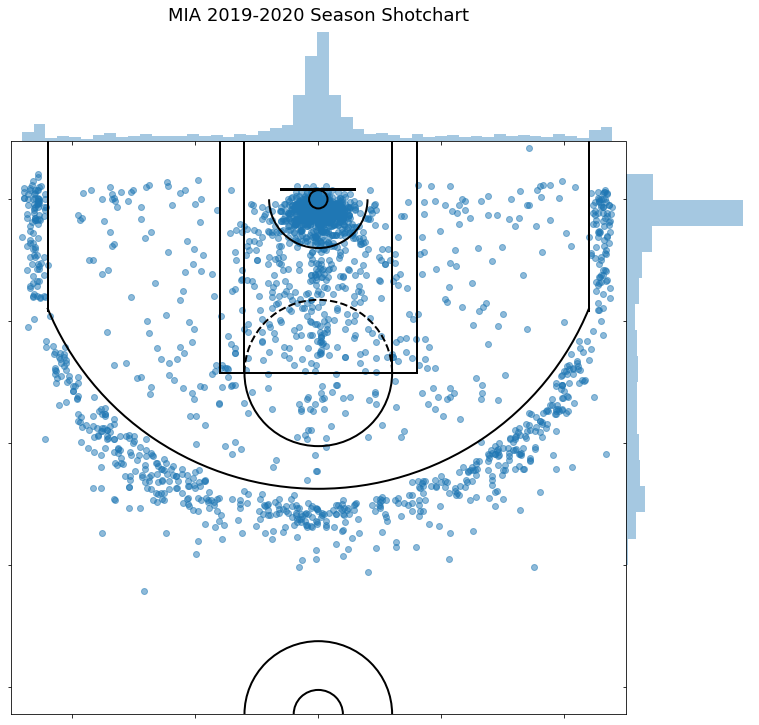

In [14]:
get_team_shotchart_for_year('MIA', '2019-2020')

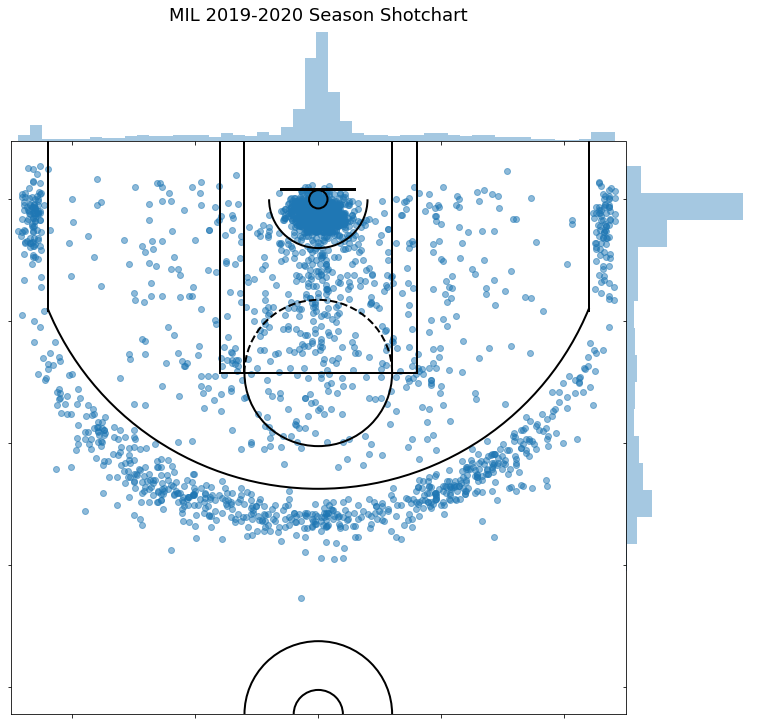

In [15]:
get_team_shotchart_for_year('MIL', '2019-2020')

ValueError: color kwarg must have one color per dataset

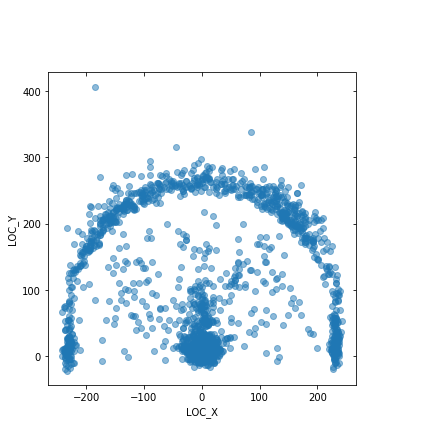

In [16]:
get_team_shotchart_for_year('HOU', '2019-2020')

/home/vishnu/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


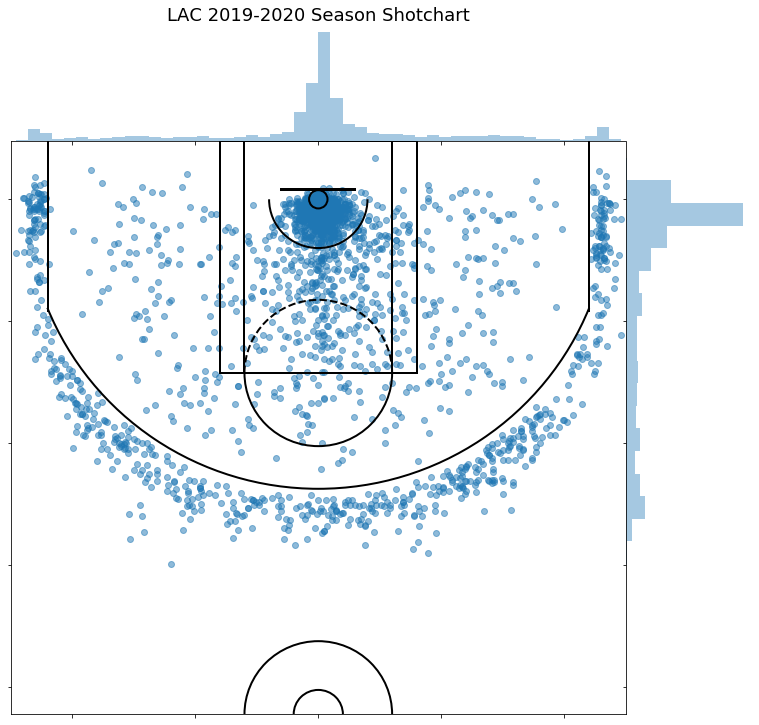

In [17]:
get_team_shotchart_for_year('LAC', '2019-2020')

ValueError: color kwarg must have one color per dataset

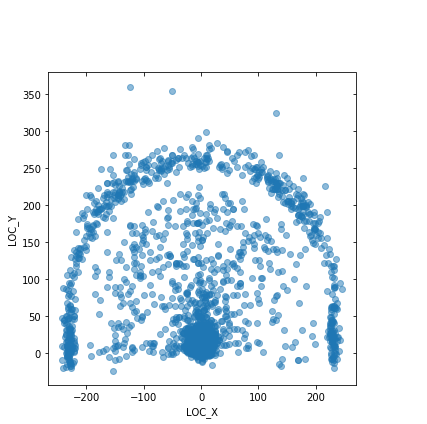

In [18]:
get_team_shotchart_for_year('LAL', '2019-2020')

ValueError: color kwarg must have one color per dataset

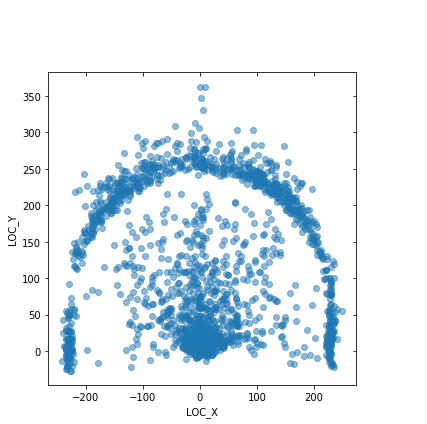

In [19]:
get_team_shotchart_for_year('DAL', '2019-2020')

ValueError: color kwarg must have one color per dataset

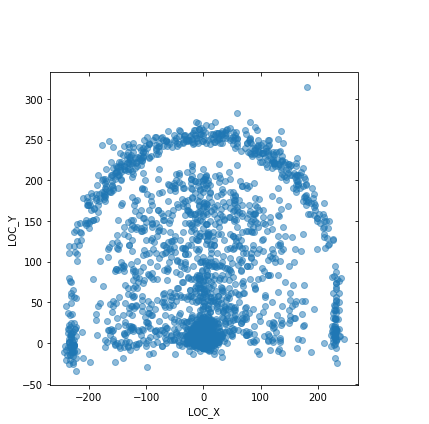

In [20]:
get_team_shotchart_for_year('SAS', '2019-2020')

ValueError: color kwarg must have one color per dataset

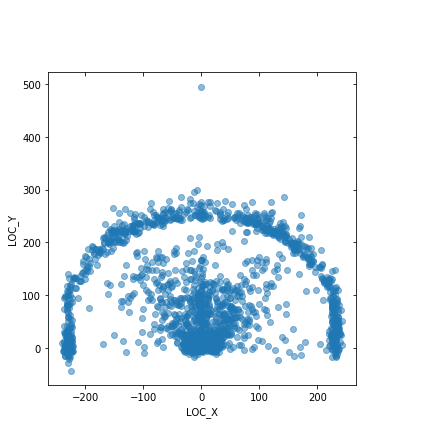

In [21]:
get_team_shotchart_for_year('UTA', '2019-2020')

ValueError: color kwarg must have one color per dataset

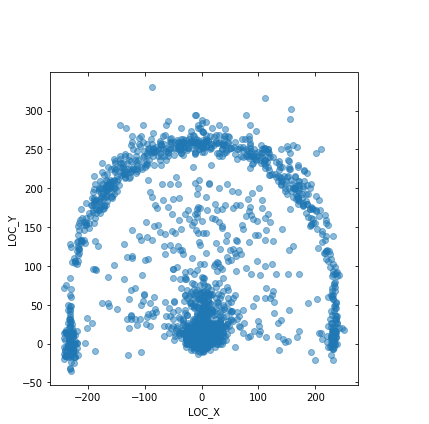

In [22]:
get_team_shotchart_for_year('TOR', '2019-2020')